In [118]:
import copy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch,torchvision
from torch import nn,save,load       #neural network module
from torch.optim import Adam      #optimizer used
from torch.utils.data import DataLoader     #load a dataset
from torchvision import datasets         
from torchvision.transforms import ToTensor       #to convert to tensor
from sklearn import metrics


In [119]:
T=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data=torchvision.datasets.MNIST('mnist_data',train=True,download=True,transform=T)  #transforming to tensor
val_data=torchvision.datasets.MNIST('mnist_data',train=False,download=True,transform=T)
print(len(val_data))
test_set,val_set=torch.utils.data.random_split(val_data,[5000,5000])

train_dl=torch.utils.data.DataLoader(train_data,64)     #batch size =64
val_dl=torch.utils.data.DataLoader(val_set,64)     
test_dl=torch.utils.data.DataLoader(test_set,64)     

10000


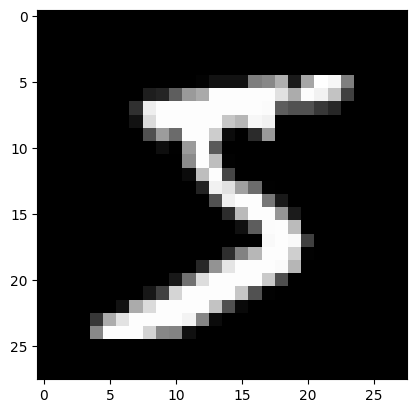

In [120]:
plt.imshow(train_data[0][0][0],cmap="gray")

In [121]:
def MNIST():
    model=nn.Sequential(
        nn.Conv2d(1,6,5,padding=2),     #input,output,filter dimensions the padding and stride
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2),
        
        nn.Conv2d(6,16,5,padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2),
        
        nn.Flatten(),
        nn.Linear(400,120),           #16*5*5
        nn.Linear(120,84),
        nn.Linear(84,10)   #total no.of digits=10
        )
    
    return model

In [122]:

#accuracy of the model

def validate(model,data):
    total=0
    correct=0
    for i,(images,labels) in enumerate(data):
        x=model(images)
        value,pred=torch.max(x,1)
        total=total+x.size(0)
        correct=correct+torch.sum(pred==labels)
    return correct/total *100    
            
  

In [123]:
def train(epochs):
    
    accuracies=[]
    max=0
    cnn=MNIST().to('cpu')
    loss=nn.CrossEntropyLoss()
    opt=Adam(cnn.parameters(),lr=0.001)
    
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_dl):
            images=images.to('cpu')
            labels=labels.to('cpu')
            
            opt.zero_grad()        #initialising to zero
            pred=cnn(images)
            l=loss(pred,labels)
            l.backward()        #backpropagation
            opt.step()             #gradient descent
        accuracy=float(validate(cnn,val_dl))  
        accuracies.append(accuracy)
        if(accuracy>max):
            best_model=copy.deepcopy(cnn)
            max=accuracy
            print("Till now best accuracy: ",accuracy)
        plt.plot(accuracies)    
        print("Epoch:",epoch+1, "Accuracy: ",accuracy)
        
    return best_model   

Till now best accuracy:  95.27999877929688
Epoch: 1 Accuracy:  95.27999877929688
Till now best accuracy:  97.47999572753906
Epoch: 2 Accuracy:  97.47999572753906
Till now best accuracy:  98.19999694824219
Epoch: 3 Accuracy:  98.19999694824219
Till now best accuracy:  98.5199966430664
Epoch: 4 Accuracy:  98.5199966430664
Till now best accuracy:  98.77999877929688
Epoch: 5 Accuracy:  98.77999877929688


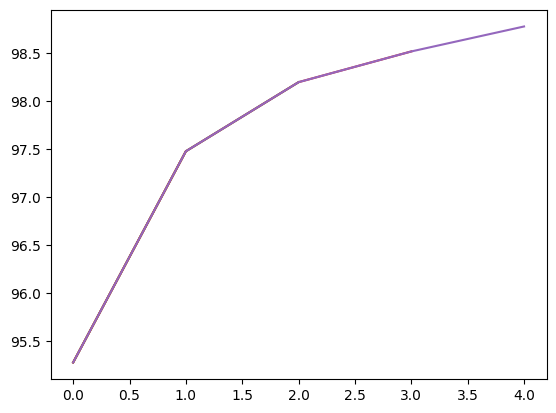

In [124]:
M=train(5)


In [125]:
#predicting the testing set
def predict(model,data):
    y_pred=[]
    y_true=[]
    for i,(images,labels) in enumerate(data):
        x=model(images)
        value,pred=torch.max(x,1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred),np.array(y_true)    

In [126]:

y_pred,y_true=predict(M,test_dl)

In [127]:
#confusion matrix

x=metrics.confusion_matrix(y_true,y_pred,labels=np.arange(0,10))
x

array([[472,   0,   0,   0,   0,   0,   1,   0,   4,   0],
       [  0, 566,   1,   1,   0,   0,   0,   0,   2,   0],
       [  0,   1, 541,   0,   0,   0,   0,   3,   1,   0],
       [  1,   0,   2, 465,   0,   1,   0,   0,   1,   0],
       [  1,   0,   0,   0, 501,   0,   1,   0,   0,   4],
       [  1,   0,   0,   7,   0, 436,   0,   2,   0,   1],
       [  0,   1,   0,   0,   1,   5, 458,   0,   2,   0],
       [  0,   2,   2,   1,   0,   0,   0, 502,   0,   4],
       [  1,   0,   1,   0,   0,   1,   0,   2, 482,   0],
       [  0,   2,   0,   1,   2,   0,   0,   2,   1, 510]], dtype=int64)

In [128]:
#saving parameters

with open('model_state.pt','wb') as f:
    save(cnn.state_dict(),f)